### Prepare imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist

### Load and combine tracking data from two CSV files

- Set the starting timestamp for the experiment.
- Load two CSV files containing tracking data from different videos.
- Adjust the `frame` and `tracker_id` columns in the second DataFrame to avoid overlaps.
- Concatenate both DataFrames into a single DataFrame.
- Compute the elapsed seconds and absolute timestamps for each frame.
- Drop unnecessary columns to create the final tracking DataFrame (`df_track`).

In [2]:
start_time = pd.Timestamp('2025-10-08 18:00:00')
df1 = pd.read_csv('../outputs/pipeline_run/tracks_video_3_24fps.csv')
df2 = pd.read_csv('../outputs/pipeline_run/tracks_video_4_24fps.csv')
df2['frame'] = df1['frame'].max() + 2 + df2['frame']
df2['tracker_id'] = df2['tracker_id'] + df1['tracker_id'].max()
df_combined = pd.concat([df1, df2], ignore_index=True)
df_combined['second'] = df_combined['frame'] / 24
df_combined['timestamp'] = start_time + pd.to_timedelta(df_combined['second'], unit='s')
df_track = df_combined.drop(
    columns=['x_min', 'x_max', 'y_min', 'y_max', 'class_id', 'confidence', 'class_name', 'frame', 'second'])
df_track

,tracker_id,lv95_E,lv95_N,timestamp
0,1,2680856.5,1248087.4,2025-10-08 18:00:00.000
1,2,2680842.8,1248096.2,2025-10-08 18:00:00.000
2,3,2680875.8,1248074.6,2025-10-08 18:00:00.000
3,4,2680826.5,1248106.8,2025-10-08 18:00:00.000
4,5,2680849.8,1248092.2,2025-10-08 18:00:00.000
...,...,...,...,...
300322,7295,2680848.5,1248092.0,2025-10-08 18:43:49.250
300323,7321,2680837.2,1248099.5,2025-10-08 18:43:49.250
300324,7373,2680827.0,1248106.2,2025-10-08 18:43:49.250
300325,7086,2680872.0,1248074.6,2025-10-08 18:43:49.250


### Compute instantaneous speed for each tracker

- Sort the tracking DataFrame by `timestamp` and `tracker_id`.
- For each tracker, shift the LV95 coordinates to align each row with its previous position.
- Calculate the time difference between consecutive positions for each tracker.
- Compute the Euclidean distance between consecutive positions.
- Calculate the instantaneous speed (in meters per second) for each tracker by dividing the distance by the time difference.

In [3]:
df_track = df_track.sort_values(['timestamp', 'tracker_id'])

df_track['lv95_E_shift'] = df_track.groupby('tracker_id')['lv95_E'].shift()
df_track['lv95_N_shift'] = df_track.groupby('tracker_id')['lv95_N'].shift()
df_track['time_diff'] = (df_track['timestamp'] - df_track.groupby('tracker_id')['timestamp'].shift()).dt.total_seconds()

df_track['distance'] = np.sqrt(
    (df_track['lv95_E'] - df_track['lv95_E_shift']) ** 2 + (df_track['lv95_N'] - df_track['lv95_N_shift']) ** 2)
df_track['speed_mps'] = df_track['distance'] / df_track['time_diff']
df_track = df_track.dropna()
df_track['speed_mps'] = df_track['speed_mps'].clip(lower=0, upper=12)
df_track

,tracker_id,lv95_E,lv95_N,timestamp,lv95_E_shift,lv95_N_shift,time_diff,distance,speed_mps
11,1,2680856.5,1248087.4,2025-10-08 18:00:00.083333333,2680856.5,1248087.4,0.083333,0.000000,0.000000
12,2,2680842.8,1248096.2,2025-10-08 18:00:00.083333333,2680842.8,1248096.2,0.083333,0.000000,0.000000
13,3,2680875.8,1248074.6,2025-10-08 18:00:00.083333333,2680875.8,1248074.6,0.083333,0.000000,0.000000
14,4,2680826.5,1248106.8,2025-10-08 18:00:00.083333333,2680826.5,1248106.8,0.083333,0.000000,0.000000
15,5,2680849.8,1248092.2,2025-10-08 18:00:00.083333333,2680849.8,1248092.2,0.083333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
300321,7182,2680858.0,1248084.8,2025-10-08 18:43:49.250000000,2680858.0,1248084.8,0.083333,0.000000,0.000000
300322,7295,2680848.5,1248092.0,2025-10-08 18:43:49.250000000,2680848.2,1248092.1,0.083333,0.316228,3.794733
300323,7321,2680837.2,1248099.5,2025-10-08 18:43:49.250000000,2680837.2,1248099.6,0.083333,0.100000,1.200000
300324,7373,2680827.0,1248106.2,2025-10-08 18:43:49.250000000,2680827.0,1248106.2,0.083333,0.000000,0.000000


### Identify and cluster stationary vehicles by time

- Filter out stationary points where the instantaneous speed is less than 0.5 m/s.
- Define a function to cluster stationary vehicles based on their spatial coordinates using DBSCAN for each time group.
- Assign a `queue_id` to each detected cluster.
- Add a new column for the floored minute of each timestamp.
- Apply the clustering function to each minute group to identify vehicle queues over time.

In [4]:
stationary = df_track[df_track['speed_mps'] < 0.5].copy()
stationary['minute'] = stationary['timestamp'].dt.floor('1min')


def cluster_by_time(group):
    coords = group[['lv95_E', 'lv95_N']].to_numpy()
    clustering = DBSCAN(eps=5, min_samples=2).fit(coords)
    group['queue_id'] = clustering.labels_
    return group


stationary = stationary.groupby('minute', group_keys=False).apply(cluster_by_time)

C:\Users\jj\AppData\Local\Temp\ipykernel_56900\2518537564.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stationary = stationary.groupby('minute', group_keys=False).apply(cluster_by_time)


### Calculate queue sizes and maximum queue length

- For each minute and detected queue, count the number of unique trackers (vehicles) present.
- Store the result as `queue_sizes`, representing the size of each queue per minute.
- Determine the maximum queue length observed across all time intervals.

In [5]:
def queue_length_m(group):
    coords = group[['lv95_E', 'lv95_N']].to_numpy()
    if len(coords) < 2:
        return 0.0
    return pdist(coords).max()  # max pairwise distance in meters


queue_lengths = (
    stationary[stationary['queue_id'] >= 0]
    .groupby(['minute', 'queue_id'])
    .apply(queue_length_m)
    .reset_index(name='queue_length_m')
)

max_queue_length_m = queue_lengths['queue_length_m'].max()

avg_queue_length_m = queue_lengths['queue_length_m'].mean()
print(max_queue_length_m)
print(avg_queue_length_m)

85.3814968247524
68.71637063466085


C:\Users\jj\AppData\Local\Temp\ipykernel_56900\4068560369.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(queue_length_m)


### Calculate average time spent in queue per tracker

- Select all time entries where each tracker was assigned to a queue (`queue_id` >= 0).
- For each tracker, determine the first and last minute they were in a queue.
- Calculate the duration each tracker spent in a queue as the difference between the last and first minute.
- Compute the average queue duration across all trackers.

In [6]:
in_queue = stationary[stationary['queue_id'] >= 0]
time_in_queue = (
    in_queue.groupby('tracker_id')['minute']
    .agg(['min', 'max'])
    .assign(duration=lambda x: (x['max'] - x['min']).dt.total_seconds())
)
avg_time_in_queue = time_in_queue['duration'].mean()

### Visualize queue length over time and display average queue duration

- Plot the maximum queue length for each minute to visualize how queue sizes change over time.
- Label the axes and add a title for clarity.
- Display the average time vehicles spent in a queue.

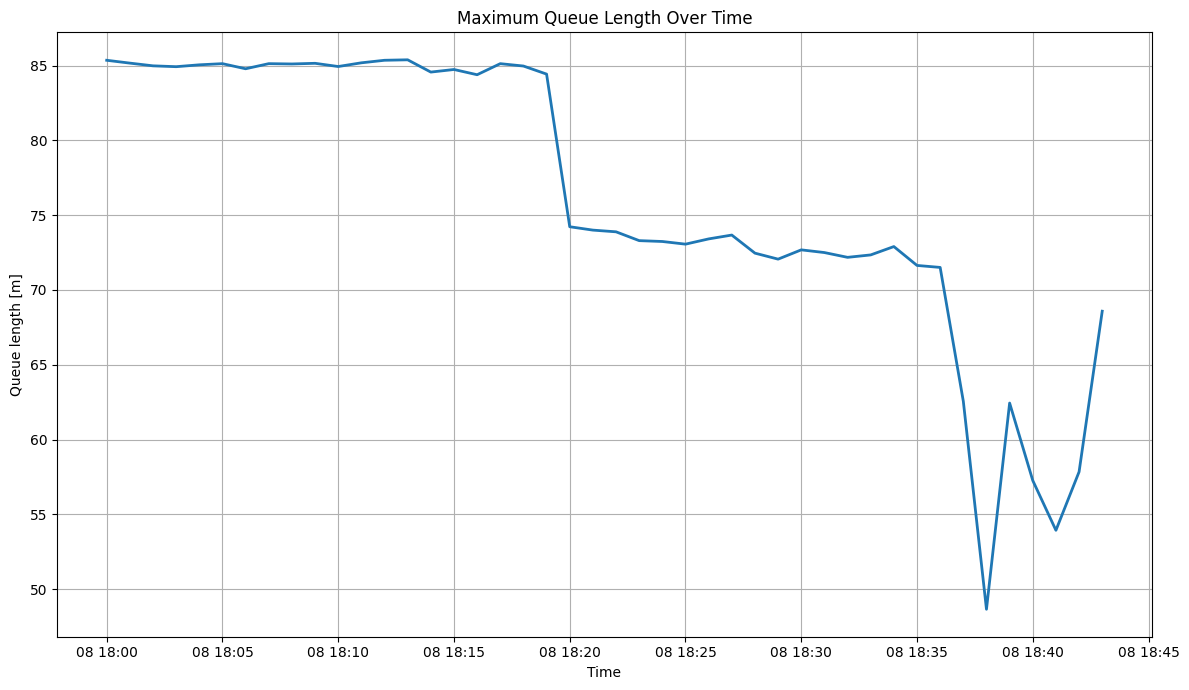

In [11]:
ts_max = (queue_lengths
          .groupby('minute', as_index=False)['queue_length_m']
          .max())

plt.figure(figsize=(12, 7))
plt.plot(ts_max['minute'], ts_max['queue_length_m'], linewidth=2)
plt.title('Maximum Queue Length Over Time')
plt.xlabel('Time')
plt.ylabel('Queue length [m]')
plt.grid()
plt.tight_layout()
plt.show()